In [145]:
import glob
import os
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
tf.random.Generator = None  # Patch for a bug
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Flatten, LSTM, MaxPooling1D, LeakyReLU, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, RepeatVector
from sklearn.metrics import confusion_matrix, classification_report 

In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), "./aclImdb_v1/aclImdb/train/pos/", "*.txt"))

pos = []

for file_path in file_list:
    with open(file_path) as f_input:
        pos.append(f_input.read())

In [3]:
pos_df = pd.DataFrame(pos, columns = ["reviews"])
pos_df["label"] = 1
pos_df["data_type"] = "train"

nRow, nCol = pos_df.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 12500 rows and 3 columns in the training set.


In [4]:
file_list = glob.glob(os.path.join(os.getcwd(), "./aclImdb_v1/aclImdb/train/neg/", "*.txt"))

neg = []

for file_path in file_list:
    with open(file_path) as f_input:
        neg.append(f_input.read())

In [5]:
neg_df = pd.DataFrame(neg, columns = ["reviews"])
neg_df["label"] = 0
neg_df["data_type"] = "train"

nRow, nCol = neg_df.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 12500 rows and 3 columns in the training set.


In [6]:
train = pos_df.append(neg_df)

nRow, nCol = train.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 25000 rows and 3 columns in the training set.


In [7]:
# Clean of white spaces
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Print statistics
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    25000 non-null  object
 1   label      25000 non-null  int64 
 2   data_type  25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


In [8]:
# Distribution of positive and negative labels
train["label"].value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [9]:
# Removing empty rows from csv 
train.dropna(axis=0,inplace=True)
nRow, nCol = train.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 25000 rows and 3 columns in the training set.


In [10]:
# Distribution of positive and negative labels
train["label"].value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [11]:
train.head()

,reviews,label,data_type
0,This is one of the best films we watched in my...,1,train
1,Spoiler This movie is about such a concept. Wi...,1,train
2,Richard Attenborough is a director whose name ...,1,train
3,"Joan Crawford had just begun her ""working girl...",1,train
4,I have just read the lead comment for this fil...,1,train


In [12]:
file_list = glob.glob(os.path.join(os.getcwd(), "./aclImdb_v1/aclImdb/test/pos/", "*.txt"))

pos_test = []

for file_path in file_list:
    with open(file_path) as f_input:
        pos_test.append(f_input.read())

In [13]:
pos_test_df = pd.DataFrame(pos_test, columns = ["reviews"])
pos_test_df["label"] = 1
pos_test_df["data_type"] = "test"

nRow, nCol = pos_test_df.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 12500 rows and 3 columns in the training set.


In [14]:
file_list = glob.glob(os.path.join(os.getcwd(), "./aclImdb_v1/aclImdb/test/neg/", "*.txt"))

neg_test = []

for file_path in file_list:
    with open(file_path) as f_input:
        neg_test.append(f_input.read())

In [15]:
neg_test_df = pd.DataFrame(neg_test, columns = ["reviews"])
neg_test_df["label"] = 0
neg_test_df["data_type"] = "test"

nRow, nCol = neg_test_df.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 12500 rows and 3 columns in the training set.


In [16]:
test = pos_test_df.append(neg_test_df)

nRow, nCol = test.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 25000 rows and 3 columns in the training set.


In [17]:
# Clean of white spaces
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Print statistics
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    25000 non-null  object
 1   label      25000 non-null  int64 
 2   data_type  25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


In [18]:
# Distribution of positive and negative labels
test["label"].value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [19]:
# Removing empty rows from csv 
test.dropna(axis=0,inplace=True)
nRow, nCol = test.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 25000 rows and 3 columns in the training set.


In [20]:
# Distribution of positive and negative labels
test["label"].value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [21]:
test.head()

,reviews,label,data_type
0,This movie is definitely one of the finest of ...,1,test
1,I recently saw this at the 2007 Palm Springs I...,1,test
2,This delightful movie tells the story of buds....,1,test
3,This movie was well done but it also made me f...,1,test
4,"""The Couch Trip"" is one of those silly comedie...",1,test


In [22]:
data = train.append(test)

nRow, nCol = data.shape
print(f'INFO: There are {nRow} rows and {nCol} columns in the training set.')

INFO: There are 50000 rows and 3 columns in the training set.


In [23]:
data["data_type"].value_counts()

test     25000
train    25000
Name: data_type, dtype: int64

In [24]:
data.head()

,reviews,label,data_type
0,This is one of the best films we watched in my...,1,train
1,Spoiler This movie is about such a concept. Wi...,1,train
2,Richard Attenborough is a director whose name ...,1,train
3,"Joan Crawford had just begun her ""working girl...",1,train
4,I have just read the lead comment for this fil...,1,train


In [25]:
def preprocess_text(rev):
    # Removing html tags
    sentence = remove_tags(rev)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [26]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [27]:
X = []
sentences = list(data['reviews'])
for rev in sentences:
    X.append(preprocess_text(rev))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.20, random_state=80)

In [29]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [31]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.840B.300d.txt', 'r', errors = 'ignore', encoding='utf-8')

for line in glove_file:
    records = line.split(' ')
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [32]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [215]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [252]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(4, activation="tanh", return_sequences=True))
# model.add(Reshape([1600], input_shape=(None, 200, 8)))
model.add(Flatten())
model.add(RepeatVector((5)))
model.add(LSTM(8, activation="tanh", return_sequences=True))
# model.add(Reshape(([128]), input_shape=(None, 8, 16)))
model.add(TimeDistributed(Dense(1)))
# model.add(Reshape(([16]), input_shape=(None, 16, 1)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=opt, loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC(num_thresholds=1200, curve='ROC', summation_method='interpolation'), 
                       'accuracy'])

In [253]:
print(model.summary())

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, 200, 300)          27748800  
_________________________________________________________________
lstm_154 (LSTM)              (None, 200, 4)            4880      
_________________________________________________________________
flatten_32 (Flatten)         (None, 800)               0         
_________________________________________________________________
repeat_vector_36 (RepeatVect (None, 5, 800)            0         
_________________________________________________________________
lstm_155 (LSTM)              (None, 5, 8)              25888     
_________________________________________________________________
time_distributed_57 (TimeDis (None, 5, 1)              9         
_________________________________________________________________
flatten_33 (Flatten)         (None, 5)               

In [254]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/25
32000/32000 [==============================] - 85s 3ms/step - loss: 0.6070 - auc_50: 0.6128 - accuracy: 0.6535 - val_loss: 0.4917 - val_auc_50: 0.7418 - val_accuracy: 0.7675
Epoch 2/25
32000/32000 [==============================] - 82s 3ms/step - loss: 0.4476 - auc_50: 0.7886 - accuracy: 0.7948 - val_loss: 0.4084 - val_auc_50: 0.8201 - val_accuracy: 0.8159
Epoch 3/25
32000/32000 [==============================] - 78s 2ms/step - loss: 0.3975 - auc_50: 0.8382 - accuracy: 0.8217 - val_loss: 0.3759 - val_auc_50: 0.8524 - val_accuracy: 0.8325
Epoch 4/25
32000/32000 [==============================] - 81s 3ms/step - loss: 0.3713 - auc_50: 0.8628 - accuracy: 0.8358 - val_loss: 0.3650 - val_auc_50: 0.8706 - val_accuracy: 0.8361
Epoch 5/25
32000/32000 [==============================] - 81s 3ms/step - loss: 0.3549 - auc_50: 0.8769 - accuracy: 0.8443 - val_loss: 0.3491 - val_auc_50: 0.8825 - val_accuracy: 0.8471
Epoch 6/25
32000/32000 [==

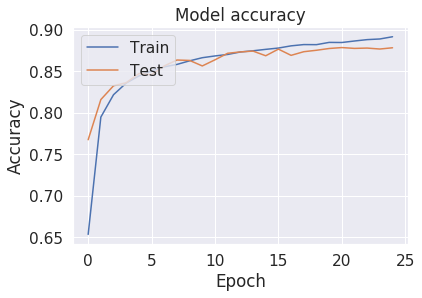

In [255]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

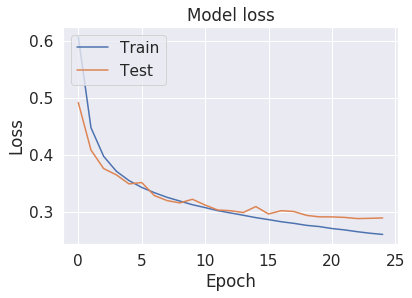

In [256]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [257]:
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
10000/10000 [==============================] - 3s 308us/step
test loss, test acc: [0.305900266456604, 0.936504602432251, 0.8734999895095825]

# Generate predictions for 3 samples
predictions shape: (3, 1)


In [258]:
model_pred = model.predict(X_test, batch_size=128, verbose=1)
# model_predicted = np.argmax(model_pred, axis=0)

10000/10000 [==============================] - 3s 295us/step


In [259]:
model_cm = confusion_matrix(y_test, model_pred.round()) 
model_cm

array([[4445,  618],
       [ 647, 4290]])

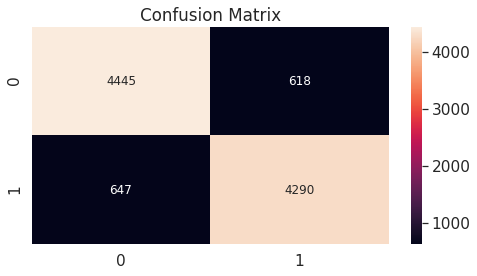

In [260]:
model_df_cm = pd.DataFrame(model_cm, range(2), range(2)) 
plt.figure(figsize = (8, 4)) 
plt.title('Confusion Matrix')
sn.set(font_scale=1.4) #for label size 
sn.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}, fmt="d") # font size 
plt.show()

In [261]:
model_report = classification_report(y_test, model_pred.round())
print(model_report)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5063
           1       0.87      0.87      0.87      4937

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

